# Importing libraries

In [5]:
import re
import os
# import spacy
import string
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

from nltk.corpus import stopwords  
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

# data file names
fake_path = "../data/Fake.csv"
true_path = "../data/True.csv"

# I. Loading and exploring data

In [24]:
# Sample data with each class taking 10000 instances
df_fake = pd.read_csv(fake_path, header=0).sample(n=10000, random_state=np.random.randint(0,40000))
df_true = pd.read_csv(true_path, header=0).sample(n=10000, random_state=np.random.randint(0,40000))

In [25]:
# Concatenate the two data frames 
df_fake['label'] = 0
df_true['label'] = 1

df = pd.concat([df_fake, df_true])
df.index = list(range(len(df.index))) # re-index the dataframe
df # print out the data frame

,title,text,subject,date,label
0,Even Staunch Republican Ben Stein Says He’d S...,Conservatives are going to be seriously shocke...,News,"March 2, 2016",0
1,White Supremacists Robocall For Trump Ahead O...,A Super PAC representing white nationalists is...,News,"February 29, 2016",0
2,WHY Ugly HATE And DIVISION In America Is Actua...,"This is Obama s legacy of hate and division, a...",left-news,"Nov 11, 2016",0
3,The New American Century: An Era of Fraud,Paul Craig RobertsIn the last years of the 20t...,US_News,"January 19, 2016",0
4,HOW OBAMA IS FORCING POOREST AMERICANS To Fend...,Is it any wonder Latino Americans are throwing...,politics,"Mar 24, 2016",0
...,...,...,...,...,...
19995,Ex-U.S. Rep. Weiner sentenced to 21 months in ...,NEW YORK (Reuters) - Former U.S. Representativ...,politicsNews,"September 25, 2017",1
19996,White House says Biden's visit is a good indic...,WASHINGTON (Reuters) - The White House on Thur...,politicsNews,"April 28, 2016",1
19997,Hate speech seeps into U.S. mainstream amid bi...,"KOKOMO, Indiana (Reuters) - The lettering is c...",politicsNews,"November 7, 2016",1
19998,Florida lieutenant governor ends bid for Senat...,(Reuters) - Florida’s Republican lieutenant go...,politicsNews,"June 22, 2016",1


# II. Exploratory Data Analysis and Data Cleaning

In [26]:
print("[INFO] Data types by columns : ")
df.info()

[INFO] Data types by columns : 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 19999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    20000 non-null  object
 1   text     20000 non-null  object
 2   subject  20000 non-null  object
 3   date     20000 non-null  object
 4   label    20000 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 937.5+ KB


In [27]:
# Dropping duplicates and re-indexing
original_row_count = len(df.index)
df = df.drop_duplicates()
df = df.reset_index(drop=True)

new_row_count = len(df.index)
print(f'[INFO] {original_row_count - new_row_count} duplicate rows dropped ...')

[INFO] 58 duplicate rows dropped ...


### We can see that some date strings do not satisfy the format "%B %d, %Y" 

In [28]:
format_ = "%B %d, %Y" # E.g : April 04, 2020
num_invalids = 0

df['date'] = df['date'].apply(lambda x : x.strip())
for _date in np.unique(df['date']):
    try:
        datetime.datetime.strptime(_date, format_)
    except:
        num_invalids += 1
        
print(f"[INFO] Number of invalid date strings : {num_invalids}")

[INFO] Number of invalid date strings : 907


In [29]:
# Replace month strings with their full forms
num_invalids = 0

short_forms = ["Jan ", "Feb ", "Mar ", "Apr ", "May ", "Jun ", "Jul ", "Aug ", "Sep ", "Oct ", "Nov ", "Dec "]
full_forms  = ["January ", "Febuary ", "March ", "April ", "May ", "June ", "July ", "August ", "September ", 
               "October ", "November ", "December "]

for i in range(len(short_forms)):
    df['date'] = df['date'].str.replace(short_forms[i], full_forms[i])
    
# Check again which date strings are still unclean
for _date in np.unique(df['date']):
    try:
        datetime.datetime.strptime(_date, format_)
    except:
        num_invalids += 1
        
print(f"[INFO] Number of invalid date strings : {num_invalids}")

[INFO] Number of invalid date strings : 66


In [30]:
# Replace 'Febuary' with "Frebuary"
num_invalids = 0
df['date'] = df['date'].str.replace("Febuary", "February")

# Check again which date strings are still unclean
for _date in np.unique(df['date']):
    try:
        datetime.datetime.strptime(_date, format_)
    except:
        num_invalids += 1
        
print(f"[INFO] Number of invalid date strings : {num_invalids}")

[INFO] Number of invalid date strings : 9


In [31]:
# Convert format '%d-%B-%y' to '%B %d, %Y'
num_invalids = 0
df['date'] = df['date'].apply(lambda x : x.replace('Feb-', 'February-'))

for _date in np.unique(df['date']):
    try:
        old = datetime.datetime.strptime(_date, '%d-%B-%y')
        new = old.strftime(format_)
        df['date'] = df['date'].str.replace(_date, new)
    except : pass
    
# Check again which date strings are still unclean
for _date in np.unique(df['date']):
    try:
        datetime.datetime.strptime(_date, format_)
    except:
        num_invalids += 1
        
print(f"[INFO] Number of invalid date strings : {num_invalids}")

[INFO] Number of invalid date strings : 4


### Now that most of the rows satisfies the date format, drop the remaining rows

In [32]:
num_invalids = 0
def is_valid(date_string):
    try:
        datetime.datetime.strptime(date_string, format_)
        return True
    except:
        return 
    
original_row_count = len(df.index)
df['date'] = df['date'].apply(lambda x : np.nan if not is_valid(x) else x)
df = df.dropna()
new_row_count = len(df.index)

print(f'[INFO] {original_row_count - new_row_count} invalid rows dropped ...')

# Check again which date strings are still unclean
for _date in np.unique(df['date']):
    try:
        datetime.datetime.strptime(_date, format_)
    except:
        num_invalids += 1
        
print(f"[INFO] Number of invalid date strings : {num_invalids}")

[INFO] 5 invalid rows dropped ...
[INFO] Number of invalid date strings : 0


### I assume that politics and politicsNews are the same type so I will merge them

In [33]:
print(np.unique(df['subject'].values))

['Government News' 'Middle-east' 'News' 'US_News' 'left-news' 'politics'
 'politicsNews' 'worldnews']


In [34]:
df['subject'] = df['subject'].str.replace("politicsNews", "politics")
print(np.unique(df['subject'].values))

['Government News' 'Middle-east' 'News' 'US_News' 'left-news' 'politics'
 'worldnews']


### Display frequencies of fake and real news by months
* Key findings :
    - The wave of fake news started its rise in late 2015 and continue to remain high until April 2017 when
    fake news started to decrease
    - In the same time, shortly after April 2017, the amount of real news skyrocketed indicating improvement in
    fake news sensorship

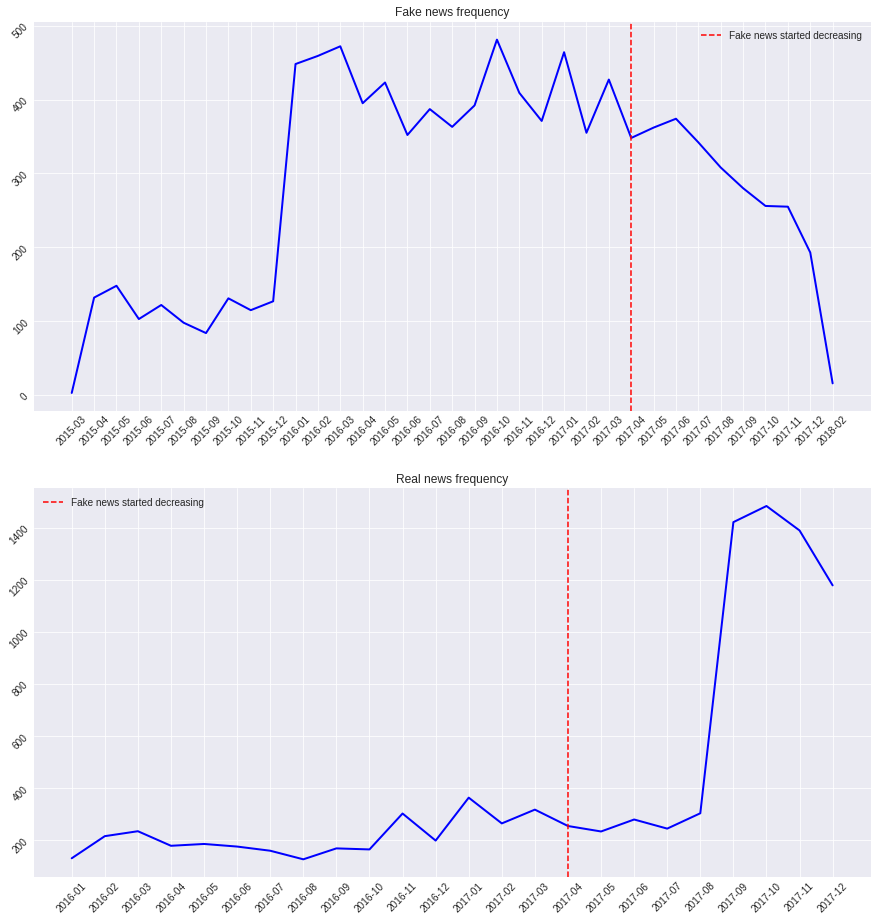

In [35]:
def split_date_to_month(date):
    d = datetime.datetime.strptime(date, format_)
    month = str(d.month).zfill(2)
    year  = str(d.year)
    
    return year + "-" + month

fig, ax = plt.subplots(2, 1, figsize=(15, 5))
df['month'] = df['date'].apply(lambda x : split_date_to_month(x))
fake_count = df[df['label'] == 0].groupby('month').count()
real_count = df[df['label'] == 1].groupby('month').count()

ax[0].plot(fake_count['label'], color='blue', linewidth=2)
ax[0].tick_params(rotation=45)
ax[0].axvline(25, color='red', label='Fake news started decreasing', linestyle="--")
ax[0].set_title("Fake news frequency")
ax[0].legend()

ax[1].plot(real_count['label'], color='blue', linewidth=2)
ax[1].tick_params(rotation=45)
ax[1].axvline(15, color='red', label='Fake news started decreasing', linestyle="--")
ax[1].set_title("Real news frequency")
ax[1].legend()

plt.subplots_adjust(top=2.5)
plt.show()

### Fake news frequency by subject
* Key findings :
    1. The most faked types of news include "News", "politics", "left-news"
    2. Less faked types of news are "Middle-east", "US_News" and "Government News"
    3. This can be attributed as a feature in model training

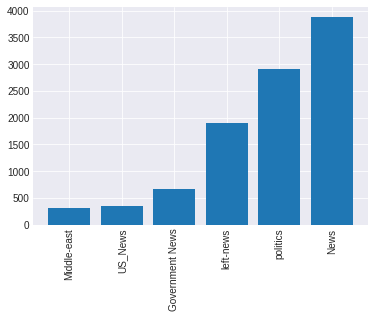

In [36]:
fake = df[df['label'] == 0]
fake_by_subjects = fake.groupby('subject').count()['label']

freq = fake_by_subjects.values

# Sort both subjects and frequency values by values
freq = fake_by_subjects.values[np.argsort(fake_by_subjects.values)]
subjects = fake_by_subjects.index[np.argsort(fake_by_subjects.values)]

plt.bar(subjects, freq)
plt.xticks(rotation=90)
plt.show()

# III. Text data cleaning and exploration
* Reference : 
    https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data

## 1. Expand contraction
    * Expanding contracted forms like we're -> we are, I've -> I have

In [37]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

print("[INFO] Expanding contraction ... ")
df['title'] = df['title'].apply(lambda x : expand_contractions(x))
df['text'] = df['text'].apply(lambda x : expand_contractions(x))
print("[INFO] Done!")

[INFO] Expanding contraction ... 
[INFO] Done!


## 2. Lowercasing text

In [38]:
print('[INFO] Lowercasing text ... ')
df['title'] = df['title'].apply(lambda x : x.lower())
df['text'] = df['text'].apply(lambda x : x.lower())
print('[INFO] Done!')

[INFO] Lowercasing text ... 
[INFO] Done!


## 3. Removing digits 

In [39]:
print('[INFO] Removing digits ... ')
df['title']=df['title'].apply(lambda x: re.sub('\w*\d\w*','', x))
df['text']=df['text'].apply(lambda x: re.sub('\w*\d\w*','', x))
print('[INFO] Done!')

[INFO] Removing digits ... 
[INFO] Done!


## 4. Removing punctuations 
* Removing characters like '!', '#', '@', ...

In [40]:
print('[INFO] Removing punctuations ... ')
df['title']=df['title'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
df['text']=df['text'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
print('[INFO] Done!')

[INFO] Removing punctuations ... 
[INFO] Done!


In [41]:
print('[INFO] Removing extra spaces ...')
df['title']=df['title'].apply(lambda x: re.sub(' +',' ',x))
df['text']=df['text'].apply(lambda x: re.sub(' +',' ',x))
print('[INFO] Done!')

[INFO] Removing extra spaces ...
[INFO] Done!


## 5. Stop words removal and lemmatization
* Stopword removal : Removing stop words like "to", "as", "if", ...
* Lemmatization    : Reducing words to its based form, e.g : men -> man, departed -> depart, ...

In [42]:
### Stopword removal using the nltk way ###
stop_words = set(stopwords.words('english')) # Assuming all nltk data is installed
lemmatizer = WordNetLemmatizer()

def filter_stopwords(text):
    word_tokens = word_tokenize(text)
    filtered = [lemmatizer.lemmatize(w) for w in word_tokens if not w in stop_words]
    
    filtered_sentence = ' '.join(filtered)
    return filtered_sentence

print('[INFO] Removing stop words and lemmatizing ... ')
df['title'] = df['title'].apply(lambda x : filter_stopwords(x))
df['text'] = df['text'].apply(lambda x : filter_stopwords(x))
print('[INFO] Done!')


### Stopword removal and lemmatization using spacy ###
#print('[INFO] Removing stop words and lemmatizing ... ')

# download model en_core_web_sm model with python3 -m spacy download en_core_web_sm 
#model = spacy.load('en_core_web_sm',disable=['parser', 'ner'])
#df['title']=df['title'].apply(lambda x: ' '.join([token.lemma_ for token in list(model(x)) if (token.is_stop==False)]))
#df['text']=df['text'].apply(lambda x: ' '.join([token.lemma_ for token in list(model(x)) if (token.is_stop==False)]))

#print('[INFO] Done!')

[INFO] Removing stop words and lemmatizing ... 
[INFO] Done!


In [43]:
print('[INFO] Data Frame after cleaning ... ')
df

[INFO] Data Frame after cleaning ... 


,title,text,subject,date,label,month
0,even staunch republican ben stein say ’ suppor...,conservative going seriously shocked oneben st...,News,"March 2, 2016",0,2016-03
1,white supremacist robocall trump ahead super t...,super pac representing white nationalist roboc...,News,"February 29, 2016",0,2016-02
2,ugly hate division america actually obama ’ fa...,obama legacy hate division acceptable use stro...,left-news,"November 11, 2016",0,2016-11
3,new american century era fraud,paul craig robertsin last year century fraud e...,US_News,"January 19, 2016",0,2016-01
4,obama forcing poorest american fend dangerous ...,wonder latino american throwing support behind...,politics,"March 24, 2016",0,2016-03
...,...,...,...,...,...,...
19937,exus rep weiner sentenced month teen isexting ...,new york reuters former u representative antho...,politics,"September 25, 2017",1,2017-09
19938,white house say biden visit good indication u ...,washington reuters white house thursday said v...,politics,"April 28, 2016",1,2016-04
19939,hate speech seeps u mainstream amid bitter cam...,kokomo indiana reuters lettering crude scrawle...,politics,"November 7, 2016",1,2016-11
19940,florida lieutenant governor end bid senate seat,reuters florida ’ republican lieutenant govern...,politics,"June 22, 2016",1,2016-06


In [44]:
print('[INFO] Storing final data ...')
df.to_pickle("df_final.gzip")

[INFO] Storing final data ...


# IV. Text data vectorization
* Comparation between Bag-of-words and TF-IDF (Not using BERT or pretrained embedding models for simplicity).
* Train the same Linear SVC model on two feature sets : Bag-of-words and TF-IDF
    to compare which feature set facilitates separating two classes better. 
* It appears that Bag-of-words gives slightly better results every time. However, Bag-of-words has some drawbacks :
  - Since the vectorizer converts sentences to vectors of fixed size, when new data has new words, this will cause the vectors to resize and we have to modify the classification model.
  - The vectors will have a lot of 0s in them, creating sparsity in the features set.

In [2]:
# Reload from check point if existed
if(os.path.exists("df_final.gzip")):
    df = pd.read_pickle("df_final.gzip")

In [3]:
features_tf_idf = TfidfVectorizer().fit_transform(df['title'])
features_bow    = CountVectorizer().fit_transform(df['title'])
targets = df['label']

[INFO] Training SVM model on TF-IDF features ... 
[INFO] Training SVM model on Bag-of-words features ...
------------------------------------------------------
[INFO] Sampling and validating models, round #1 ...
[INFO] Sampling and validating models, round #2 ...
[INFO] Sampling and validating models, round #3 ...
[INFO] Sampling and validating models, round #4 ...
[INFO] Sampling and validating models, round #5 ...
[INFO] Sampling and validating models, round #6 ...
[INFO] Sampling and validating models, round #7 ...
[INFO] Sampling and validating models, round #8 ...
[INFO] Sampling and validating models, round #9 ...
[INFO] Sampling and validating models, round #10 ...


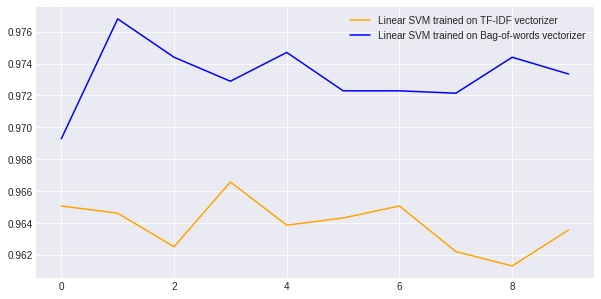

In [4]:
accuracies_tf_idf = []
accuracies_bow    = []

model_tf_idf = SVC(kernel='linear', C=1.0)
model_bow    = SVC(kernel='linear', C=1.0)

print('[INFO] Training SVM model on TF-IDF features ... ')
X_train, X_test, Y_train, Y_test = train_test_split(features_tf_idf, targets, test_size=0.333, random_state=40000)
model_tf_idf.fit(X_train, Y_train)

print('[INFO] Training SVM model on Bag-of-words features ...')
X_train, X_test, Y_train, Y_test = train_test_split(features_bow, targets, test_size=0.333, random_state=40000)
model_bow.fit(X_train, Y_train)

print('------------------------------------------------------')
for i in range(10):
    print(f'[INFO] Sampling and validating models, round #{i+1} ...')    
    X_train, X_test, Y_train, Y_test = train_test_split(features_tf_idf, targets, test_size=0.333, shuffle=True)
    predictions = model_tf_idf.predict(X_test)
    accuracy = accuracy_score(predictions, Y_test)
    accuracies_tf_idf.append(accuracy)
    
    X_train, X_test, Y_train, Y_test = train_test_split(features_bow, targets, test_size=0.333, shuffle=True)
    predictions = model_bow.predict(X_test)
    accuracy = accuracy_score(predictions, Y_test)
    accuracies_bow.append(accuracy)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(accuracies_tf_idf, color='orange', label="Linear SVM trained on TF-IDF vectorizer")
ax.plot(accuracies_bow,    color='blue',   label="Linear SVM trained on Bag-of-words vectorizer")
ax.legend()
plt.show()

# V. Models building